In [1]:
import sys
sys.path.append("./libs/")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import shift_data, print_hp,print_line, graficarTodo, split_df, graficarClases, plot_metrics, plot_cm, plot_roc, plot_prc, plot_probs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import datetime
import os
import keras_tuner as kt
from keras_tuner import HyperModel
import keras.metrics as metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.losses import BinaryCrossentropy

# Carga de datos

In [3]:
df = pd.read_csv('./data/PERU_DATA_DIFF.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 1995-03-01 to 2022-09-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PN02312FM  331 non-null    float64
 1   PD37974BM  331 non-null    float64
 2   PD37976BM  331 non-null    float64
 3   PN02028AM  331 non-null    float64
 4   PD37972BM  331 non-null    float64
 5   Class      331 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.1 KB


In [5]:
df.describe()

,PN02312FM,PD37974BM,PD37976BM,PN02028AM,PD37972BM,Class
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.007333,0.003140,0.004260,0.002553,0.005870,0.117825
std,0.009396,0.014114,0.008570,0.006737,0.007171,0.322889
min,-0.023065,-0.044618,-0.021834,-0.024735,-0.014352,0.000000
25%,0.001821,-0.004155,-0.000763,-0.001154,0.001794,0.000000
50%,0.007930,0.003949,0.004378,0.002729,0.006407,0.000000
75%,0.011984,0.010879,0.009684,0.006601,0.009957,0.000000
max,0.042614,0.036833,0.026307,0.027911,0.025603,1.000000


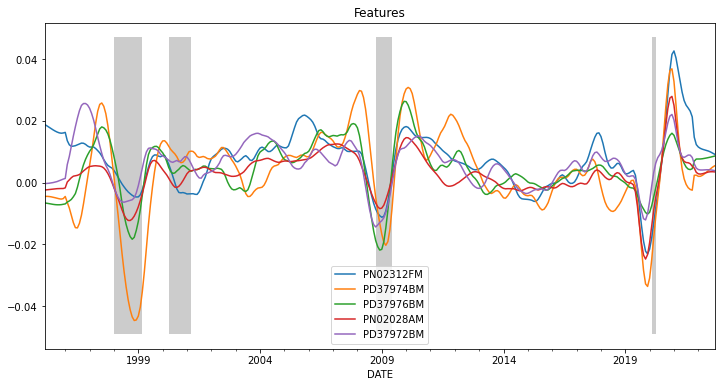

In [6]:
graficarTodo(df,'Features')

# Dividir Datos

In [7]:
target_col = ['Class']
features = df.columns[(df.columns!=target_col[0])]
df_train, df_test = split_df(df,0.3)

# Normalizar

In [8]:
df_x_train = df_train[features].copy()
df_y_train = df_train[target_col].copy()
df_x_test = df_test[features].copy()
df_y_test = df_test[target_col].copy()

scaler = StandardScaler()

df_x_train.iloc[:,:] = scaler.fit_transform(df_x_train)
df_x_test.iloc[:,:] = scaler.transform(df_x_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)

# Construccion

In [9]:
n_features = len(features)

In [10]:
res_peru_1 = {
    'MLP_PERU':['./modelamiento/modelos/MLP_PERU_1_20221231_0044_2.h5',15],
    'CNN_PERU':['./modelamiento/modelos/CNN_PERU_1_20221230_2244_12.h5', 9],
    'LSTM_PERU':['./modelamiento/modelos/LSTM_PERU_1_20221230_2342_3.h5', 4],
    'GRU_PERU':['./modelamiento/modelos/GRU_PERU_1_20221230_2312_13.h5', 7],
    'MLP_PERU_FT':['./modelamiento/modelos/MLP_TL_PERU_1_20230112_1919_10.h5', 16],
    'CNN_PERU_FT':['./modelamiento/modelos/CNN_TL_PERU_1_20221230_2208_1.h5', 7],
    'LSTM_PERU_FT':['./modelamiento/modelos/LSTM_TL_PERU_1_20221230_1934_0.h5', 6],
    'GRU_PERU_FT':['./modelamiento/modelos/GRU_TL_PERU_1_20221230_2036_0.h5', 6],
}
res_peru_6 = {
    'MLP_PERU':['./modelamiento/modelos/MLP_PERU_6_20221231_0044_16.h5', 12],
    'CNN_PERU':['./modelamiento/modelos/CNN_PERU_6_20221230_2244_11.h5', 8],
    'LSTM_PERU':['./modelamiento/modelos/LSTM_PERU_6_20221230_2342_18.h5', 9],
    'GRU_PERU':['./modelamiento/modelos/GRU_PERU_6_20221230_2312_9.h5', 8],
    'MLP_PERU_FT':['./modelamiento/modelos/MLP_TL_PERU_6_20230112_1919_8.h5', 15],
    'CNN_PERU_FT':['./modelamiento/modelos/CNN_TL_PERU_6_20221230_2208_2.h5', 15],
    'LSTM_PERU_FT':['./modelamiento/modelos/LSTM_TL_PERU_6_20221230_1934_3.h5', 6],
    'GRU_PERU_FT':['./modelamiento/modelos/GRU_TL_PERU_6_20221230_2036_0.h5', 5],
}
res_peru_12 = {
    'MLP_PERU':['./modelamiento/modelos/MLP_PERU_12_20221231_0044_11.h5', 13],
    'CNN_PERU':['./modelamiento/modelos/CNN_PERU_12_20221230_2244_12.h5', 8],
    'LSTM_PERU':['./modelamiento/modelos/LSTM_PERU_12_20221230_2342_9.h5', 4],
    'GRU_PERU':['./modelamiento/modelos/GRU_PERU_12_20221230_2312_18.h5', 8],
    'MLP_PERU_FT':['./modelamiento/modelos/MLP_TL_PERU_12_20230112_1919_0.h5', 13],
    'CNN_PERU_FT':['./modelamiento/modelos/CNN_TL_PERU_12_20221230_2208_8.h5', 23],
    'LSTM_PERU_FT':['./modelamiento/modelos/LSTM_TL_PERU_12_20221230_1934_8.h5', 6],
    'GRU_PERU_FT':['./modelamiento/modelos/GRU_TL_PERU_12_20221230_2036_5.h5', 7],
}

# Evaluar

In [11]:
def predecir(models: dict, n_steps_out):
    df_res = df_y_test.copy()
    df_res = df_res.shift(-n_steps_out)
    df_val = pd.DataFrame()

    for key in models.keys():
        n_steps_in = models[key][1]
        model = load_model(models[key][0])
        #x_train, y_train = shift_data(df_x_train, df_y_train, n_steps_in, n_steps_out)
        x_test, y_test, indexes = shift_data(df_x_test, df_y_test, n_steps_in, n_steps_out)
        y_pred = model(x_test)
        df = pd.DataFrame()
        df['DATE'] = indexes
        df['DATE'] = pd.to_datetime(df['DATE'])
        df[key] = y_pred
        df = df.set_index('DATE')
        df_res = pd.concat([df_res, df[key]], axis=1)
    
        res = model.evaluate(x_test, y_test, verbose=0)
        df_val_n = pd.DataFrame({
            'tp': [res[1]],
            'fp': [res[2]],
            'tn': [res[3]],
            'fn': [res[4]],
            'accuracy': [res[5]],
            'precision': [res[6]],
            'recall': [res[7]],
            'auc': [res[8]],
            'prc': [res[9]],
        }, index = [key])
        df_val = pd.concat([df_val, df_val_n])

    return df_res, df_val

In [12]:
df_1, df_1_val = predecir(res_peru_1,1)
#graficarTodo(df_1,"Predicción de Recesión con 1 mes de anticipación")
df_1_val

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_PERU,3.0,59.0,22.0,0.0,0.297619,0.048387,1.0,0.938272,0.230769
CNN_PERU,3.0,46.0,41.0,0.0,0.488889,0.061224,1.0,0.992337,0.800786
LSTM_PERU,3.0,56.0,36.0,0.0,0.410526,0.050847,1.0,0.972826,0.375000
GRU_PERU,3.0,5.0,84.0,0.0,0.945652,0.375000,1.0,0.986891,0.698178
MLP_PERU_FT,3.0,28.0,52.0,0.0,0.662651,0.096774,1.0,0.975000,0.428571
CNN_PERU_FT,3.0,56.0,33.0,0.0,0.391304,0.050847,1.0,0.870787,0.115385
LSTM_PERU_FT,3.0,49.0,41.0,0.0,0.473118,0.057692,1.0,0.977778,0.428571
GRU_PERU_FT,3.0,34.0,56.0,0.0,0.634409,0.081081,1.0,0.977778,0.417678


In [13]:
df_6, df_6_val = predecir(res_peru_6,6)
#graficarTodo(df_6,"Predicción de Recesión con 6 meses de anticipación")
df_6_val

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_PERU,3.0,42.0,37.0,0.0,0.487805,0.066667,1.000000,0.805907,0.083548
CNN_PERU,3.0,32.0,51.0,0.0,0.627907,0.085714,1.000000,0.875502,0.127527
LSTM_PERU,0.0,0.0,82.0,3.0,0.964706,0.000000,0.000000,0.843496,0.106117
GRU_PERU,1.0,4.0,79.0,2.0,0.930233,0.200000,0.333333,0.915663,0.169586
MLP_PERU_FT,3.0,2.0,74.0,0.0,0.974684,0.600000,1.000000,0.980263,0.492783
CNN_PERU_FT,3.0,22.0,54.0,0.0,0.721519,0.120000,1.000000,0.877193,0.271412
LSTM_PERU_FT,3.0,41.0,44.0,0.0,0.534091,0.068182,1.000000,0.901961,0.157199
GRU_PERU_FT,3.0,59.0,27.0,0.0,0.337079,0.048387,1.000000,1.000000,1.000000


In [14]:
df_12, df_12_val = predecir(res_peru_12,12)
#graficarTodo(df_12,"Predicción de Recesión con 6 meses de anticipación")
df_12_val

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_PERU,0.0,16.0,56.0,3.0,0.746667,0.0,0.0,0.539352,0.040607
CNN_PERU,0.0,27.0,50.0,3.0,0.625000,0.0,0.0,0.456710,0.032146
LSTM_PERU,0.0,0.0,81.0,3.0,0.964286,0.0,0.0,0.320988,0.023958
GRU_PERU,0.0,0.0,77.0,3.0,0.962500,0.0,0.0,0.393939,0.029403
MLP_PERU_FT,0.0,46.0,26.0,3.0,0.346667,0.0,0.0,0.141204,0.022747
CNN_PERU_FT,0.0,47.0,15.0,3.0,0.230769,0.0,0.0,0.139785,0.026709
LSTM_PERU_FT,0.0,7.0,72.0,3.0,0.878049,0.0,0.0,0.443038,0.030892
GRU_PERU_FT,0.0,33.0,45.0,3.0,0.555556,0.0,0.0,0.181624,0.022086
